### Решение для одного набора данных

In [3]:
# !pip install vrplib
import vrplib
import copy
import time
import zipfile
import glob
import numpy as np
import matplotlib.pyplot as plt
import itertools

from matplotlib.cm import rainbow
from types import SimpleNamespace
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
tqdm.pandas()


In [4]:
with zipfile.ZipFile("Vrp-Set-A.zip","r") as zip_ref:
    zip_ref.extractall()

In [5]:
# Получаем информцию о файлах в нужной директории
solution_files = (glob.glob("A/*.sol"))
vrp_files = (glob.glob("A/*.vrp"))

In [6]:
dfs_sol = {text_file: vrplib.read_solution(text_file)
           for text_file in solution_files}

dfs_vrp = {text_file: vrplib.read_instance(text_file)
           for text_file in vrp_files}

In [7]:
dfs_sol

{'A\\A-n32-k5.sol': {'routes': [[21, 31, 19, 17, 13, 7, 26],
   [12, 1, 16, 30],
   [27, 24],
   [29, 18, 8, 9, 22, 15, 10, 25, 5, 20],
   [14, 28, 11, 4, 23, 3, 2, 6]],
  'cost': 784},
 'A\\A-n33-k5.sol': {'routes': [[15, 17, 9, 3, 16, 29],
   [12, 5, 26, 7, 8, 13, 32, 2],
   [20, 4, 27, 25, 30, 10],
   [23, 28, 18, 22],
   [24, 6, 19, 14, 21, 1, 31, 11]],
  'cost': 661},
 'A\\A-n33-k6.sol': {'routes': [[5, 2, 20, 15, 9, 3, 8, 4],
   [31, 24, 23, 26, 22],
   [17, 11, 29, 19, 7],
   [10, 12, 21],
   [28, 27, 30, 16, 25, 32],
   [13, 6, 18, 1, 14]],
  'cost': 742},
 'A\\A-n34-k5.sol': {'routes': [[18, 21, 32, 28, 31, 25, 13],
   [4, 26, 5, 24, 30],
   [10, 17, 19, 11, 23, 1, 27],
   [20, 33, 16, 22, 12, 3, 9, 2],
   [14, 29, 8, 15, 6, 7]],
  'cost': 778},
 'A\\A-n36-k5.sol': {'routes': [[9, 6, 3, 4, 19, 31, 12],
   [28, 14, 34, 23, 2, 35, 8, 15],
   [16, 11, 24, 27, 25, 5, 20],
   [10, 7, 26],
   [1, 22, 32, 13, 17, 30, 29, 33, 18, 21]],
  'cost': 799},
 'A\\A-n37-k5.sol': {'routes': [[

In [8]:
dfs_vrp

{'A\\A-n32-k5.vrp': {'name': 'A-n32-k5',
  'comment': '(Augerat et al, No of trucks: 5, Optimal value: 784)',
  'type': 'CVRP',
  'dimension': 32,
  'edge_weight_type': 'EUC_2D',
  'capacity': 100,
  'node_coord': array([[82, 76],
         [96, 44],
         [50,  5],
         [49,  8],
         [13,  7],
         [29, 89],
         [58, 30],
         [84, 39],
         [14, 24],
         [ 2, 39],
         [ 3, 82],
         [ 5, 10],
         [98, 52],
         [84, 25],
         [61, 59],
         [ 1, 65],
         [88, 51],
         [91,  2],
         [19, 32],
         [93,  3],
         [50, 93],
         [98, 14],
         [ 5, 42],
         [42,  9],
         [61, 62],
         [ 9, 97],
         [80, 55],
         [57, 69],
         [23, 15],
         [20, 70],
         [85, 60],
         [98,  5]]),
  'demand': array([ 0, 19, 21,  6, 19,  7, 12, 16,  6, 16,  8, 14, 21, 16,  3, 22, 18,
         19,  1, 24,  8, 12,  4,  8, 24, 24,  2, 20, 15,  2, 14,  9]),
  'depot': array([0]

In [9]:
def plot_solution(solution, data,  name="CVRP solution"):
    """
    Вывод путей в переданном решении.
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    cmap = rainbow(np.linspace(0, 1, len(solution.routes)))

    for idx, route in enumerate(solution.routes):
        ax.plot(
            [data["node_coord"][loc][0] for loc in [0] + route + [0]],
            [data["node_coord"][loc][1] for loc in [0] + route + [0]],
            color=cmap[idx],
            marker='.'
        )
        
    kwargs = dict(label="Депо", zorder=3, marker="*", s=750)
    ax.scatter(*data["node_coord"][0], c="tab:red", **kwargs) 

    ax.set_title(f"{name}\n Суммарное расстояние: {solution.cost}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend(frameon=False, ncol=3)
    fig.tight_layout()

#     fig.savefig(f'{name}.png') 


In [10]:
example_sol =SimpleNamespace(**list(dfs_sol.values())[0])
example_data = list(dfs_vrp.values())[0]

example_sol, example_data

(namespace(routes=[[21, 31, 19, 17, 13, 7, 26],
                   [12, 1, 16, 30],
                   [27, 24],
                   [29, 18, 8, 9, 22, 15, 10, 25, 5, 20],
                   [14, 28, 11, 4, 23, 3, 2, 6]],
           cost=784),
 {'name': 'A-n32-k5',
  'comment': '(Augerat et al, No of trucks: 5, Optimal value: 784)',
  'type': 'CVRP',
  'dimension': 32,
  'edge_weight_type': 'EUC_2D',
  'capacity': 100,
  'node_coord': array([[82, 76],
         [96, 44],
         [50,  5],
         [49,  8],
         [13,  7],
         [29, 89],
         [58, 30],
         [84, 39],
         [14, 24],
         [ 2, 39],
         [ 3, 82],
         [ 5, 10],
         [98, 52],
         [84, 25],
         [61, 59],
         [ 1, 65],
         [88, 51],
         [91,  2],
         [19, 32],
         [93,  3],
         [50, 93],
         [98, 14],
         [ 5, 42],
         [42,  9],
         [61, 62],
         [ 9, 97],
         [80, 55],
         [57, 69],
         [23, 15],
         [20,

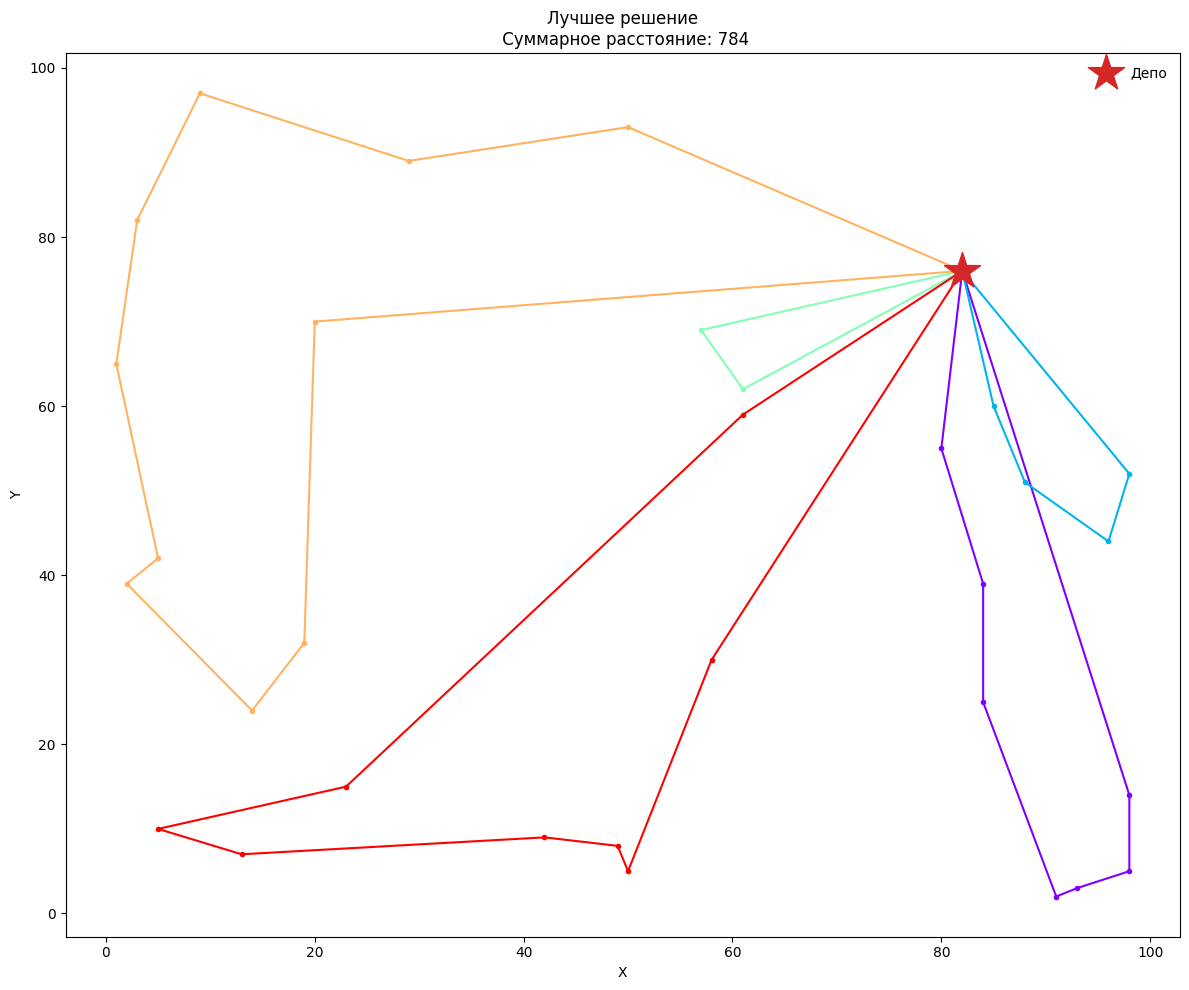

In [11]:
plot_solution(example_sol, example_data, name="Лучшее решение")

In [12]:
class CvrpState:
    """
    Solution state for CVRP. It has two data members, routes and unassigned.
    Routes is a list of list of integers, where each inner list corresponds to
    a single route denoting the sequence of customers to be visited. A route
    does not contain the start and end depot. Unassigned is a list of integers, 
    each integer representing an unassigned customer.
    """

    def __init__(self, routes, data, unassigned=None):
        self.routes = routes
        self.unassigned = unassigned if unassigned is not None else []
        self.data = data

    def copy(self):
        return CvrpState(copy.deepcopy(self.routes), copy.deepcopy(self.data),self.unassigned.copy())

    def objective(self):
        """
        Вычисляется суммарная стоимость всех путей.
        """
        return sum(route_cost(route, self.data) for route in self.routes)
    
    @property
    def cost(self):
        """
        Используется для графика.
        """
        return self.objective()

    def find_route(self, customer):
        """
        Возвращает путь, который содержит переданного клиента.
        """
        for route in self.routes:
            if customer in route:
                return route

        raise ValueError(f"Решение не содержит клиента {customer}.")
        
def route_cost(route, data):
    distances = data["edge_weight"]
    tour = [0] + route + [0]

    return sum(distances[tour[idx]][tour[idx + 1]]
               for idx in range(len(tour) - 1))

In [13]:
class removal:
    def __init__(self, data, degree_of_destruction=0.05):
        self.data = data
        self.degree_of_destruction = degree_of_destruction
        self.customers_to_remove = int((data["dimension"] - 1) * degree_of_destruction) # число клиентов, которое хотим удалить
        
    def neighbors(self, customer):
        """
        Возвращает ближайших соседей кроме депо.
        """
        locations = np.argsort(self.data["edge_weight"][customer])
        return locations[locations != 0]

    def random_removal(self, state, rnd_state):
        """
        Удаляется число случайно выбранных клиентов
        """
        destroyed = state.copy() # запоминаем пути

        for customer in rnd_state.choice(
            range(1, self.data["dimension"]), self.customers_to_remove, replace=False # случайно выбираем клиентов
        ):
            destroyed.unassigned.append(customer) # добавляем в разрушенные
            route = destroyed.find_route(customer)# находим путь содержащий клиента
            route.remove(customer)# убираем его из пути

        return self.remove_empty_routes(destroyed)
    
    def minimum_route_removal(self, state, rnd_state):
        """
        Этот оператор ищет маршрут с минимальным количеством клиентов и случайным
        образом выбирает узел из этого маршрута. Цель данного оператора заключается в 
        сокращении общего количества маршрутов. 
        """
        destroyed = state.copy() # запоминаем пути
        for _ in range(self.customers_to_remove):
            
            route = sorted(destroyed.routes, key=len)[0]
            if len(route) >=1:
                rnd_customer = np.random.choice(route, replace=False) # случайно выбираем клиента

                destroyed.unassigned.append(rnd_customer) # добавляем в разрушенные
                route = destroyed.find_route(rnd_customer)# находим путь содержащий клиента
                route.remove(rnd_customer)# убираем его из пути
                destroyed = self.remove_empty_routes(destroyed)

        return destroyed
    
    def worst_distance_removal(self, state):
        """
        Этот оператор выбирает клиента с наиболее высокой стоимостью на каждой итерации. 
        Стоимость каждого клиента рассчитывается как сумма расстояний от предыдущего и 
        непосредственного клиента на маршруте. Для каждой итерации эта
        стоимость рассчитывается для всех узлов во всех маршрутах. 
        Если выбрана максимальная сумма, он удаляет node. 
        """
        destroyed = state.copy() # запоминаем пути
        for _ in range(self.customers_to_remove):
            removal_customer = None
            removal_roat = None
            best_cost = None
            
            for route in destroyed.routes:
                for idx, customer in enumerate(route):
                    cost = self.removal_cost(customer, route, idx)
                    if best_cost is None or cost > best_cost:
                        best_cost = cost
                        removal_customer = customer
                        removal_route = route


            destroyed.unassigned.append(removal_customer) # добавляем в разрушенные
            route = destroyed.find_route(removal_customer)# находим путь содержащий клиента
            route.remove(removal_customer)
            destroyed = self.remove_empty_routes(destroyed)
            
        return destroyed
    


    def removal_cost(self, customer, route, idx):
            """
            Вычисляет выгоду при удалении клиета с позиции idx в пути route.
            """
            dist = self.data["edge_weight"]# расстояния
            pred = 0 if idx == 0 else route[idx - 1]# рассматриваем элемент до
            succ = 0 if idx == (len(route)-1) else route[idx + 1] # рассматриваем элемент после

            # Величина выгоды от удаления
            return dist[pred][customer] + dist[customer][succ]          

        


    def remove_empty_routes(self, state):
        """
        Удаляем пустые пути после удаления клиентов
        """
        state.routes = [route for route in state.routes if len(route) != 0]
        return state

In [15]:
class repair:
    def __init__(self, data):
        self.data = data 
        
    def random_repair(self, state, rnd_state):
        rnd_state.shuffle(state.unassigned)
        while len(state.unassigned) != 0:
            customer = state.unassigned.pop()# достаем неназначенного клиента
            route_id_list = list()
            for route in state.routes:
                for idx in range(len(route) + 1):
                    if self.can_insert(customer, route):
                        route_id_list.append([route, idx])            
            indices = rnd_state.choice(len(route_id_list))
            insert_route, insert_idx = route_id_list[indices]
            
            if insert_route is not None:# если нашли, вставляем
                insert_route.insert(insert_idx, customer)
            else:#иначе начинаем новый путь 
                state.routes.append([customer])
        return state


    def greedy_repair(self, state, rnd_state):
        """
        Вставляет неназначенных клиентов по наилучшему маршруту. 
        Если нет возможных вставок, то создается новый маршрут.
        """
        rnd_state.shuffle(state.unassigned)

        while len(state.unassigned) != 0:
            customer = state.unassigned.pop()# достаем неназначенного клиента
            route, idx = self.best_insert(customer, state)# ищем, куда его лучше вставить

            if route is not None:# если нашли, вставляем
                route.insert(idx, customer)
            else:#иначе начинаем новый путь 
                state.routes.append([customer])

        return state


    def best_insert(self, customer, state):
        """
        Ищет наилучший возможный route и idx (номер в пути) для вставки customer.
        Возвращает (None, None) если подходящие значения не найдены
        """
        best_cost, best_route, best_idx = None, None, None

        for route in state.routes:
            for idx in range(len(route) + 1):

                if self.can_insert(customer, route):
                    cost = self.insert_cost(customer, route, idx)

                    if best_cost is None or cost < best_cost: # запоминаем лучшие значения
                        best_cost, best_route, best_idx = cost, route, idx

        return best_route, best_idx


    def can_insert(self, customer, route):
        """
        Проверка, превышения вместимости транспорта при добавлении клиента в путь
        """
        total = self.data["demand"][route].sum() + self.data["demand"][customer]
        return total <= self.data["capacity"]


    def insert_cost(self, customer, route, idx):
        """
        Вычисляет стоимость вставки клиета на позицию idx в путь route.
        """
        dist = self.data["edge_weight"]# расстояния
        pred = 0 if idx == 0 else route[idx - 1]# рассматриваем элемент до
        succ = 0 if idx == len(route) else route[idx] # рассматриваем элемент после

        # Увеличение стоимости добавления клиента, минус стоимость удаления старой грани
        return dist[pred][customer] + dist[customer][succ] - dist[pred][succ]

In [16]:
class solutions:
    def __init__(self, data):
        self.data = data 
        
    def neighbors(self, customer):
        """
        Поиск ближайшего соседа клиента, не включая склад
        """
        locations = np.argsort(self.data["edge_weight"][customer])
        return locations[locations != 0]


    def nearest_neighbor(self):
        """        
        Нахождение решения, итеративно строя пути, где ближайший клиент
        добавляется  пока для данного пути не привышена вместимость транспорта.
        """
        routes = []
        unvisited = set(range(1, self.data["dimension"]))

        while unvisited:
            route = [0]  # Начинаем depot
            route_demands = 0

            while unvisited:
                # Add the nearest unvisited customer to the route till max capacity
                current = route[-1] 
                nearest = [nb for nb in self.neighbors(current) if nb in unvisited][0]

                if route_demands + self.data["demand"][nearest] > self.data["capacity"]:# если превысили demand, то прерываем
                    break

                route.append(nearest)# добавляем ближайшего соседа
                unvisited.remove(nearest)#nearest_neighbor посетили соседа
                route_demands += self.data["demand"][nearest] #потратились на требования вершины

            customers = route[1:]  # Remove the depot
            routes.append(customers)        
        return CvrpState(routes, self.data)

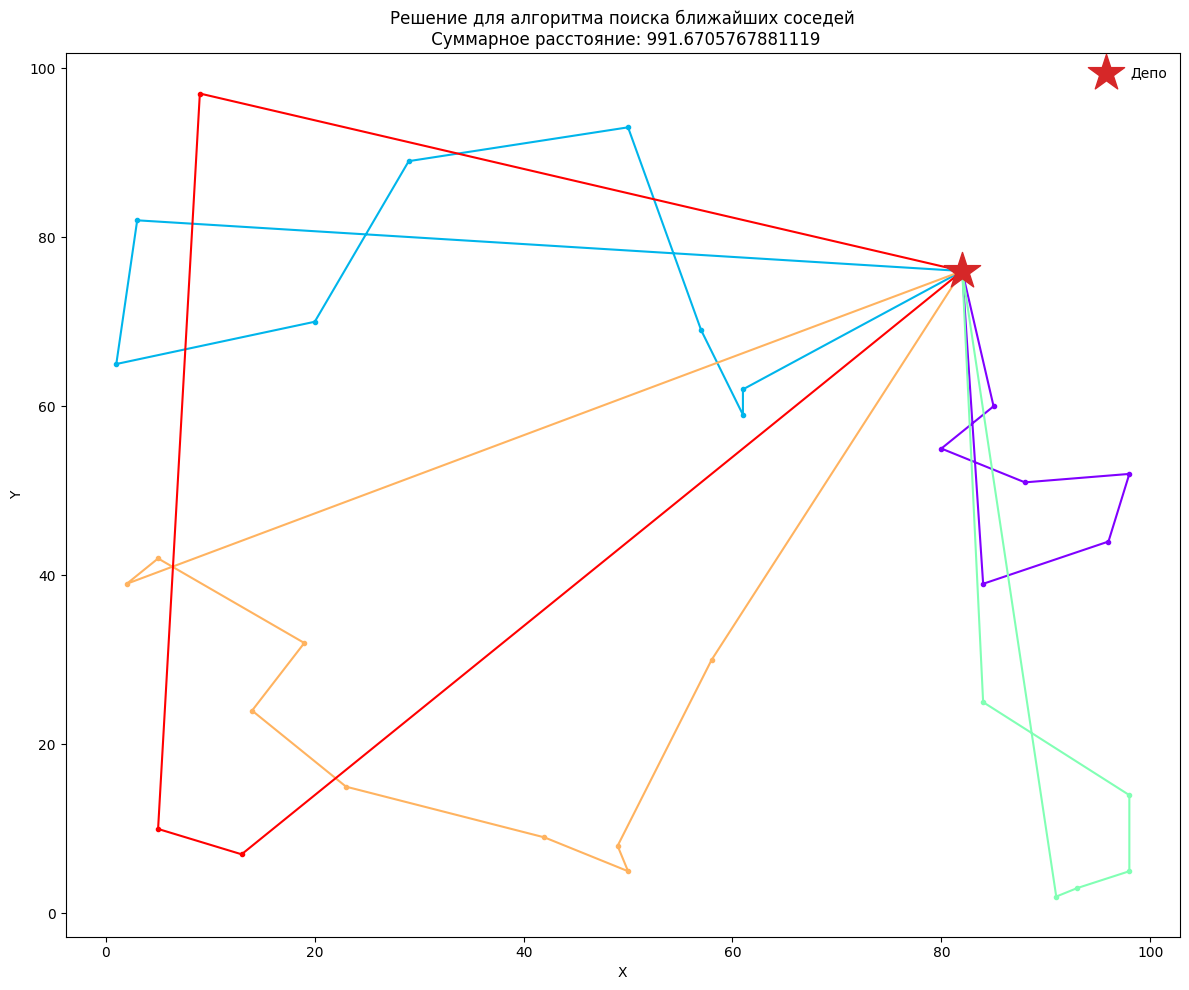

In [17]:
plot_solution(solutions(example_data).nearest_neighbor(), example_data, 'Решение для алгоритма поиска ближайших соседей')


In [18]:
def LNS(example_data):
    """
    Алгоритм LNS.
    Возвращает, лучшее решение и list суммарной стоимости на итерациях алгоритма.
    """
    solution_best = solutions(example_data).nearest_neighbor()
    
    cost_list = [solution_best.cost]

    np.random.seed(1234)
    time0 = 0
    time_last = 1000 # 200000
    
    while time0!= time_last:
        time0 += 1
        removal_modles = removal(example_data, degree_of_destruction=0.1)
        removed_sol = removal_modles.random_removal(solution_best.copy(), np.random)
        
        repaired_sol = repair(example_data).greedy_repair(removed_sol.copy(), np.random)
        
        if repaired_sol.cost < solution_best.cost:
            solution_best = repaired_sol.copy()
        cost_list.append(repaired_sol.cost)
    return solution_best, cost_list


In [19]:
%%time
result , cost_list= LNS(example_data)

CPU times: total: 891 ms
Wall time: 920 ms


In [20]:
ar = np.array([(1, 2), (3, 4)])
indices = np.random.choice(ar.shape[0])


k , kk = ar[indices]

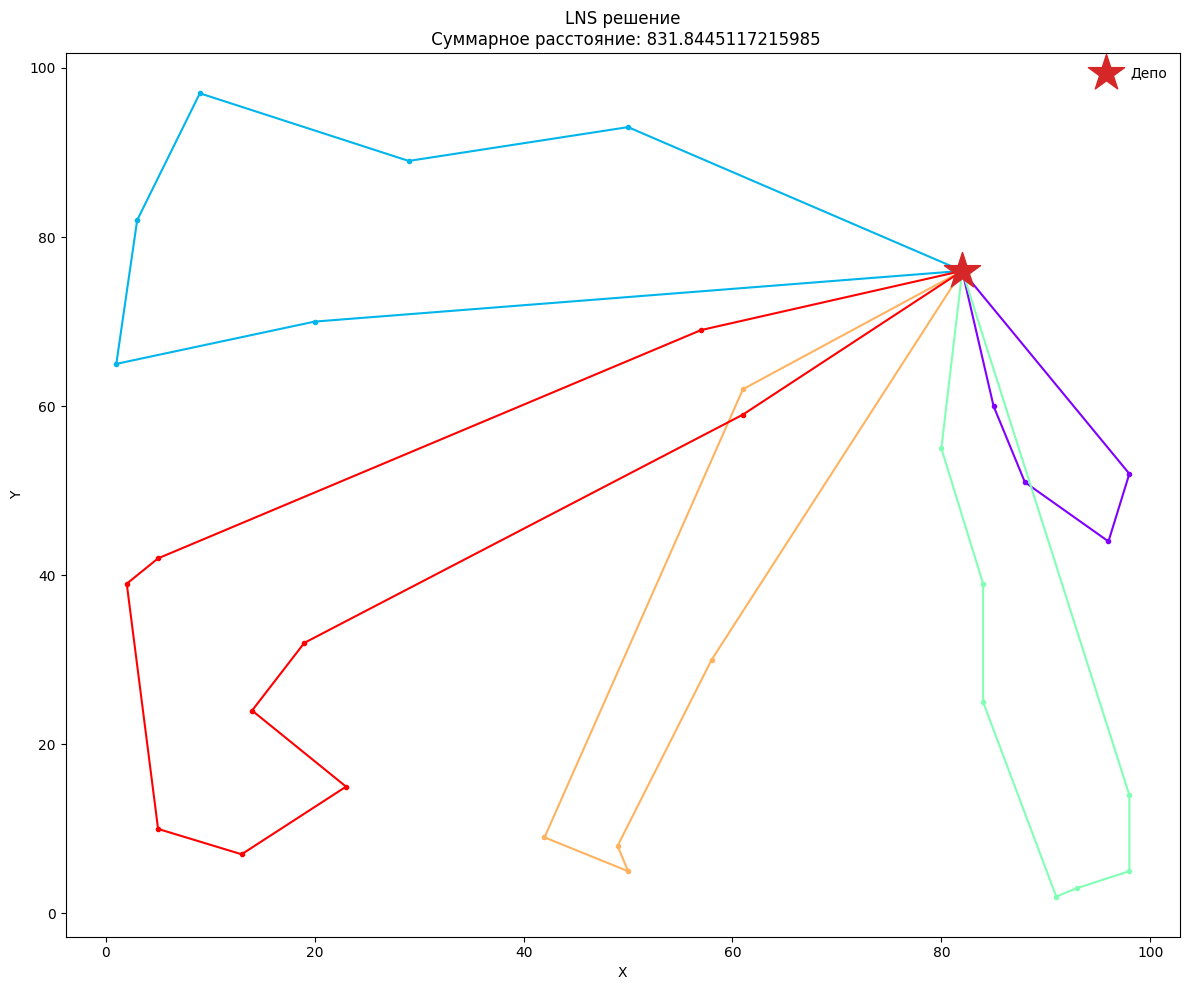

In [21]:
plot_solution(result, example_data, 'LNS решение')


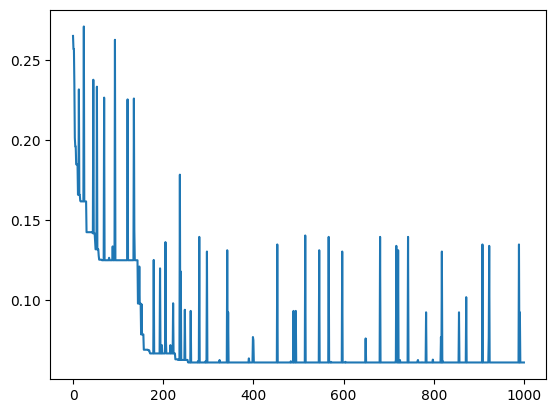

In [22]:
plt.plot(range(len(cost_list)), np.abs(np.array(cost_list) - example_sol.cost)/example_sol.cost)

In [23]:
def softmax(x):
    """Вычисляет softmax."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [24]:
def ALNS(example_data, t_start, t_min, cooling_rate, sigma_1, sigma_2, sigma_3, degree_of_destruction_removal=0.1, 
         number_renew=5, psi =0.2):
    
    """
    Алгоритм ALNS.
    """
    solution_best = solutions(example_data).nearest_neighbor()
    solution_current = solution_best.copy()
    solution_new = solution_best.copy()

    
    w_removal_list = np.array([1]*3)
    w_repair_list = np.array([1]*2)
    
    c_removal_list, n_removal_list = np.array([0]*3), np.array([0]*3)
    c_repair_list, n_repair_list = np.array([0]*2), np.array([0]*2)
    
    cost_list = list()
    t = t_start

    np.random.seed(123)

    while t > t_min:
    
        random_index_removal = np.random.choice(range(3), p=softmax(w_removal_list))
        random_index_repair = 0#np.random.choice(range(1), p=softmax(w_repair_list)) #1
        
        removal_modles = removal(example_data, degree_of_destruction=degree_of_destruction_removal)
        
        removal_operations_list = [removal_modles.random_removal, removal_modles.minimum_route_removal, 
                                   removal_modles.worst_distance_removal]# возможные функции removal
        repair_modles = repair(example_data)
        repair_operations_list = [repair_modles.greedy_repair]# возможные функции repair, убрал repair_modles.random_repair,
            
        if random_index_removal == 2:
            solution_new = removal_operations_list[random_index_removal](solution_new)
        else:
            solution_new = removal_operations_list[random_index_removal](solution_new, np.random)
            
        solution_new = repair_operations_list[random_index_repair](solution_new, np.random)

        n_removal_list[random_index_removal] += 1

        if solution_new.cost < solution_current.cost:
            solution_current = solution_new.copy()
            if solution_current.cost < solution_best.cost:
                solution_best = solution_current.copy()
                c_removal_list[random_index_removal] += sigma_1
            else:
                c_removal_list[random_index_removal] += sigma_2
                
        else:
            v = np.exp(-(solution_new.cost - solution_current.cost)/t)
            
            epsilon = np.random.rand()
            if epsilon <= v:
                solution_current = solution_new.copy()
                c_removal_list[random_index_removal] += sigma_3
                
        t = cooling_rate * t
        if (np.sum(n_repair_list.astype(int)) % number_renew == 0):
            w_removal_list = [(1 - psi) * w + psi * c / n if n > 0 else w for w, n, c in zip(w_removal_list, n_removal_list, c_removal_list)]
            
            n_removal_list = np.zeros(len(n_removal_list)).astype(int)
            
            c_removal_list = np.zeros(len(c_removal_list))
            
            
        cost_list.append(solution_current.cost)
    return solution_best, cost_list

             
        
            

    


In [26]:
%%time
result_ALNS ,cost_list_ALNS = ALNS(example_data, t_start=20000, t_min =0.01, cooling_rate = 0.999, sigma_1=10, 
                                   sigma_2=5, sigma_3=2, degree_of_destruction_removal=0.1, number_renew=200, psi =0.3)


CPU times: total: 12.4 s
Wall time: 12.6 s


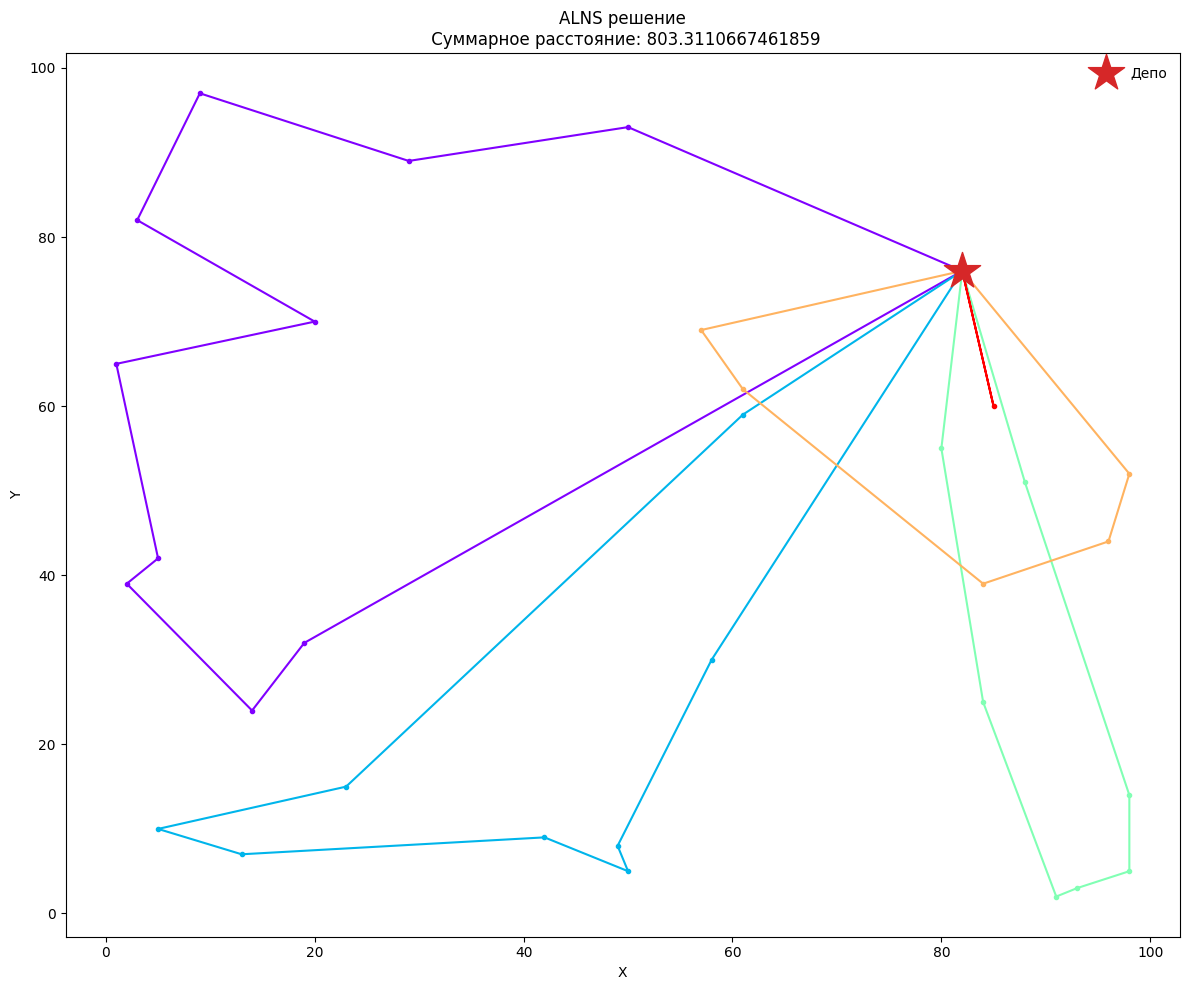

In [27]:
plot_solution(result_ALNS, example_data, 'ALNS решение')


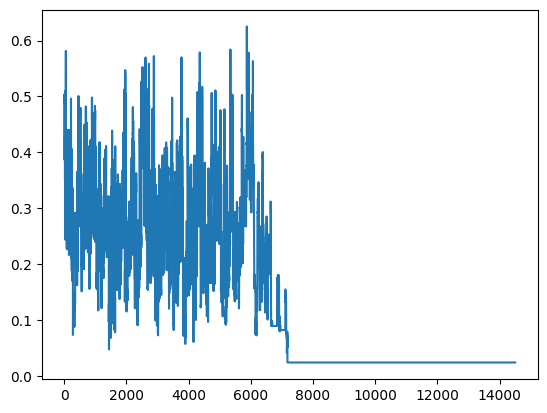

In [28]:
plt.plot(range(len(cost_list_ALNS)), np.abs(np.array(cost_list_ALNS) - example_sol.cost)/example_sol.cost)

### Dataset A

In [325]:
def calculate(example_sol, example_data, t_start=20000, t_min =0.01, cooling_rate = 0.999, sigma_1=14, 
                                   sigma_2=6, sigma_3=2, degree_of_destruction_removal=0.1, number_renew=50, 
              psi =0.3):

    result_ALNS ,cost_list_ALNS = ALNS(example_data, t_start=t_start, t_min =t_min, cooling_rate = cooling_rate, 
                                       sigma_1=sigma_1, sigma_2=sigma_2, sigma_3=sigma_3, 
                                       degree_of_destruction_removal=degree_of_destruction_removal, 
                                       number_renew=number_renew, 
                                       psi =psi)
    
    return (example_data['dimension'], abs(result_ALNS.cost- example_sol.cost)/example_sol.cost)

In [327]:
dfs_sol

{'A\\A-n32-k5.sol': {'routes': [[21, 31, 19, 17, 13, 7, 26],
   [12, 1, 16, 30],
   [27, 24],
   [29, 18, 8, 9, 22, 15, 10, 25, 5, 20],
   [14, 28, 11, 4, 23, 3, 2, 6]],
  'cost': 784},
 'A\\A-n33-k5.sol': {'routes': [[15, 17, 9, 3, 16, 29],
   [12, 5, 26, 7, 8, 13, 32, 2],
   [20, 4, 27, 25, 30, 10],
   [23, 28, 18, 22],
   [24, 6, 19, 14, 21, 1, 31, 11]],
  'cost': 661},
 'A\\A-n33-k6.sol': {'routes': [[5, 2, 20, 15, 9, 3, 8, 4],
   [31, 24, 23, 26, 22],
   [17, 11, 29, 19, 7],
   [10, 12, 21],
   [28, 27, 30, 16, 25, 32],
   [13, 6, 18, 1, 14]],
  'cost': 742},
 'A\\A-n34-k5.sol': {'routes': [[18, 21, 32, 28, 31, 25, 13],
   [4, 26, 5, 24, 30],
   [10, 17, 19, 11, 23, 1, 27],
   [20, 33, 16, 22, 12, 3, 9, 2],
   [14, 29, 8, 15, 6, 7]],
  'cost': 778},
 'A\\A-n36-k5.sol': {'routes': [[9, 6, 3, 4, 19, 31, 12],
   [28, 14, 34, 23, 2, 35, 8, 15],
   [16, 11, 24, 27, 25, 5, 20],
   [10, 7, 26],
   [1, 22, 32, 13, 17, 30, 29, 33, 18, 21]],
  'cost': 799},
 'A\\A-n37-k5.sol': {'routes': [[

In [328]:
# Поиск параметров 
t_start_list =[20000, 30000]
t_min_list = [0.01]
cooling_rate_list = [0.999, 0.995]
sigma_1_list = [10, 14]
sigma_2_list = [5, 6]
sigma_3_list = [2]
degree_of_destruction_removal_list = [0.1, 0.2]
number_renew_list = [50]
psi_list = [0.3]

In [289]:
grid_params_list = (list(itertools.product(t_start_list, t_min_list, cooling_rate_list, sigma_1_list, sigma_2_list,sigma_3_list, 
                       degree_of_destruction_removal_list, number_renew_list, psi_list)))
len(grid_params_list)

32

In [321]:
sol_grid_list = [list(dfs_sol.values())[int(len(dfs_sol)*k)] for k in [0.99]]#0.25,0.3 0.5, 0.75, 0.85, 
data_grid_list = [list(dfs_vrp.values())[int(len(dfs_vrp)*k)] for k in [ 0.99]]#0.25, 0.3, 0.5, 0.75,0.85,

In [322]:
%%time
parm_list_mean = list()
for params in tqdm(grid_params_list):
    results_params = [calculate(SimpleNamespace(**sol_val), data_val, *params) for
                             sol_val, data_val in zip(sol_grid_list, data_grid_list)]
        parm_list_mean.append(np.mean([er[1] for er in results_params]))

  0%|          | 0/32 [00:00<?, ?it/s]

CPU times: total: 19min 42s
Wall time: 20min 16s


In [335]:
%%time

results_A = Parallel(n_jobs=4)(delayed(calculate)(SimpleNamespace(**sol_val), data_val) for
                             sol_val, data_val in tqdm(zip(list(dfs_sol.values()), list(dfs_vrp.values()))))
    

0it [00:00, ?it/s]

CPU times: total: 78.1 ms
Wall time: 2min 42s


In [336]:
results_A

[(32, 0.029946187507467772),
 (33, 0.025251743247586868),
 (33, 0.009556885014258372),
 (34, 0.019199149463927742),
 (36, 0.045702126236578045),
 (37, 0.010780740899804186),
 (37, 0.04711123529088818),
 (38, 0.021860656553816506),
 (39, 0.04705557423305409),
 (39, 0.029808434969305204),
 (44, 0.07835585107771609),
 (45, 0.0546217265686247),
 (45, 0.08974155532736965),
 (46, 0.04579672485678102),
 (48, 0.0795434885700158),
 (53, 0.0691495630744067),
 (54, 0.10238482911681661),
 (55, 0.06254046167723547),
 (60, 0.1002238372038559),
 (61, 0.10613095626289898),
 (62, 0.15993560964189077),
 (63, 0.13118502509592486),
 (63, 0.1338437112768821),
 (64, 0.11550905876688675),
 (65, 0.091100960851189),
 (69, 0.10325227834999198),
 (80, 0.15412110534996093)]

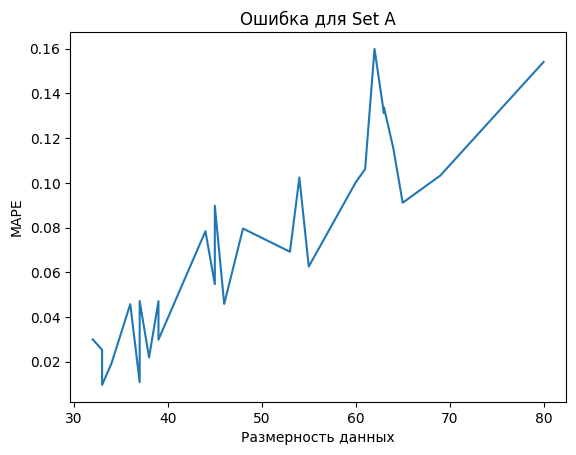

In [463]:
plot_A_err = plt.plot([i[0] for i in results_A], [i[1] for i in results_A])
plt.title("Ошибка для Set A")
plt.ylabel("MAPE")
plt.xlabel("Размерность данных")

# Saving a plotted graph as an Image 
plt.savefig("Ошибка для Set A") 
plt.show()  


In [251]:
list_A_time = list()
for sol_val, data_val in tqdm(zip(list(dfs_sol.values()), list(dfs_vrp.values()))):
    start = time.time()
    calculate(SimpleNamespace(**sol_val), data_val)
    end = time.time()
    list_A_time.append(end - start)


0it [00:00, ?it/s]

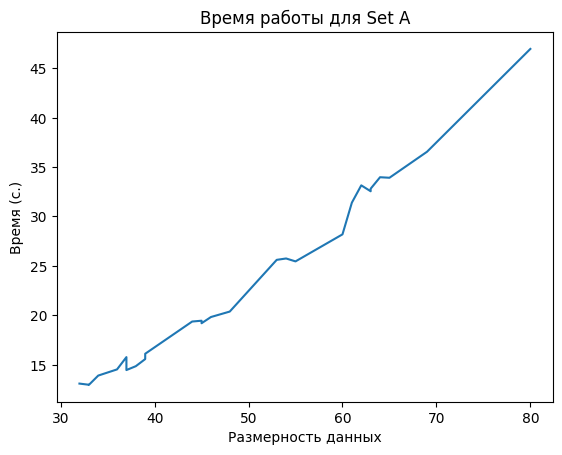

In [464]:
plt.plot([i[0] for i in results_A],list_A_time)
plt.title("Время работы для Set A")
plt.ylabel("Время (с.)")
plt.xlabel("Размерность данных")

# Saving a plotted graph as an Image 
plt.savefig("Время работы для Set A") 
plt.show()  

### Dataset B

In [338]:
with zipfile.ZipFile("Vrp-Set-B.zip","r") as zip_ref:
    zip_ref.extractall()

In [358]:
# All files and directories ending with .txt and that don't begin with a dot:
solution_files_B = (glob.glob("B/*.sol"))
vrp_files_B = (glob.glob("B/*.vrp"))

# vrp_files

# zip_file = zipfile.ZipFile('Vrp-Set-A.zip')

dfs_sol_B = {text_file: vrplib.read_solution(text_file)
           for text_file in solution_files_B}

dfs_vrp_B = {text_file: vrplib.read_instance(text_file)
           for text_file in vrp_files_B}

In [341]:
results_B = Parallel(n_jobs=4)(delayed(calculate)(SimpleNamespace(**sol_val), data_val) for
                             sol_val, data_val in tqdm(zip(list(dfs_sol_B.values()), list(dfs_vrp_B.values()))))

0it [00:00, ?it/s]

In [342]:
results_B

[(31, 0.02313968396565021),
 (34, 0.004112025197744095),
 (35, 0.007280133238087842),
 (38, 0.018204459511511097),
 (39, 0.08165866884289508),
 (41, 0.030182810573165818),
 (43, 0.024722094888748762),
 (44, 0.06559379165123455),
 (45, 0.02974282318599594),
 (45, 0.07882532450281286),
 (50, 0.016453537675490553),
 (50, 0.0635775895769587),
 (51, 0.00802091130776364),
 (52, 0.020556985503283033),
 (56, 0.06837965429306007),
 (57, 0.028570979721480667),
 (57, 0.06660510916276421),
 (63, 0.10780830973132766),
 (64, 0.06909040656892361),
 (66, 0.06245068442347379),
 (67, 0.11757183396032017),
 (68, 0.07114289161782297),
 (78, 0.08824068312358195)]

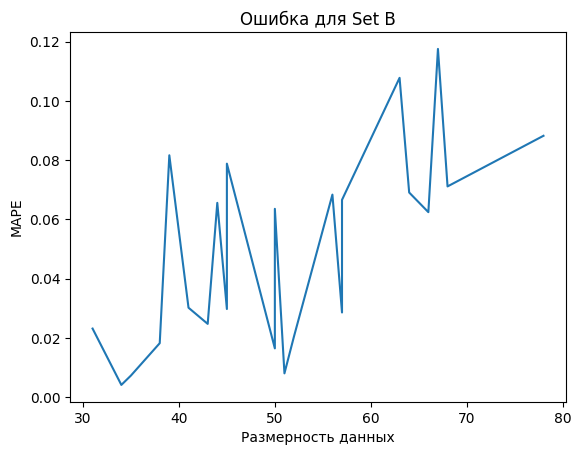

In [465]:
plt.plot([i[0] for i in results_B], [i[1] for i in results_B])
plt.title("Ошибка для Set B")
plt.ylabel("MAPE")
plt.xlabel("Размерность данных")

# plt.savefig("Ошибка для Set B") 
# plt.show()  

In [344]:
list_B_time = list()
for sol_val, data_val in tqdm(zip(list(dfs_sol_B.values()), list(dfs_vrp_B.values()))):
    start = time.time()
    calculate(SimpleNamespace(**sol_val), data_val)
    end = time.time()
    list_B_time.append(end - start)


0it [00:00, ?it/s]

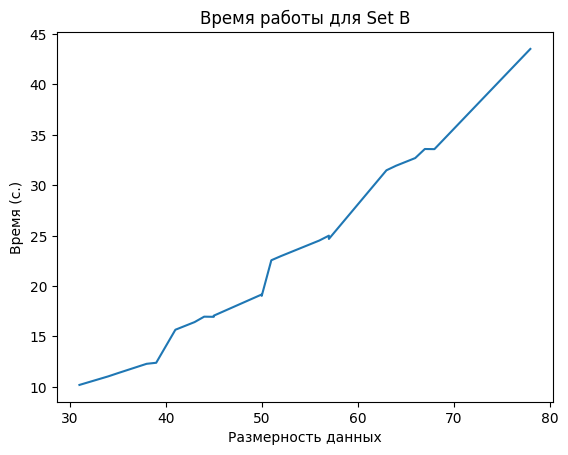

In [466]:
plt.plot([i[0] for i in results_B],list_B_time)
plt.title("Время работы для Set B")
plt.ylabel("Время (с.)")
plt.xlabel("Размерность данных")

# plt.savefig("Время работы для Set B") 
# plt.show()  

### Dataset E


In [365]:
with zipfile.ZipFile("Vrp-Set-E.zip","r") as zip_ref:
    zip_ref.extractall()

In [366]:
solution_files_E = (glob.glob("E/*.sol"))
vrp_files_E = (glob.glob("E/*.vrp"))

dfs_sol_E = {text_file: vrplib.read_solution(text_file)
           for text_file in solution_files_E}

dfs_vrp_E = {text_file: vrplib.read_instance(text_file)
           for text_file in vrp_files_E}

In [373]:
results_E = Parallel(n_jobs=4)(delayed(calculate)(SimpleNamespace(**sol_val), data_val) for
                             sol_val, data_val in tqdm(zip(list(dfs_sol_E.values()), list(dfs_vrp_E.values()))))

0it [00:00, ?it/s]

In [398]:
[el['dimension'] for el in dfs_vrp_E.values()]

[101, 101, 13, 22, 23, 30, 31, 33, 51, 76, 76, 76, 76]

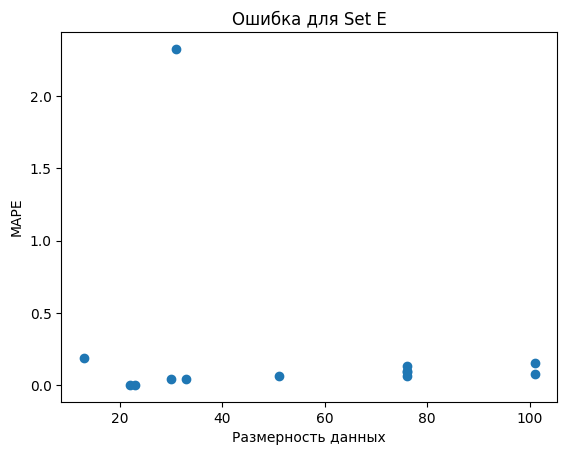

In [467]:
res1 = [i[0] for i in results_E[2:]] + [i[0] for i in results_E[:2]]
res2 = [i[1] for i in results_E[2:]] +[i[1] for i in results_E[:2]]

plt.scatter(res1, res2)
plt.title("Ошибка для Set E")
plt.ylabel("MAPE")
plt.xlabel("Размерность данных")

# plt.savefig("Ошибка для Set E") 
# plt.show()  

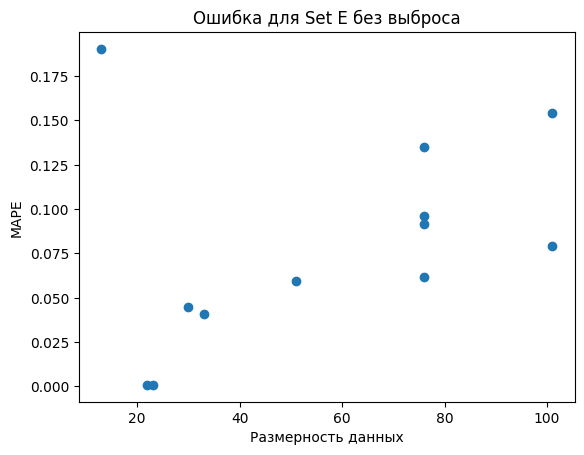

In [468]:

plt.scatter(res1[:4] + res1[5:], 
         res2[:4] + res2[5:])
plt.title("Ошибка для Set E без выброса")
plt.ylabel("MAPE")
plt.xlabel("Размерность данных")

# plt.savefig("Ошибка для Set E без выброса") 
# plt.show()  

In [363]:
list_E_time = list()
for sol_val, data_val in tqdm(zip(list(dfs_sol_E.values()), list(dfs_vrp_E.values()))):
    start = time.time()
    calculate(SimpleNamespace(**sol_val), data_val)
    end = time.time()
    list_E_time.append(end - start)

0it [00:00, ?it/s]

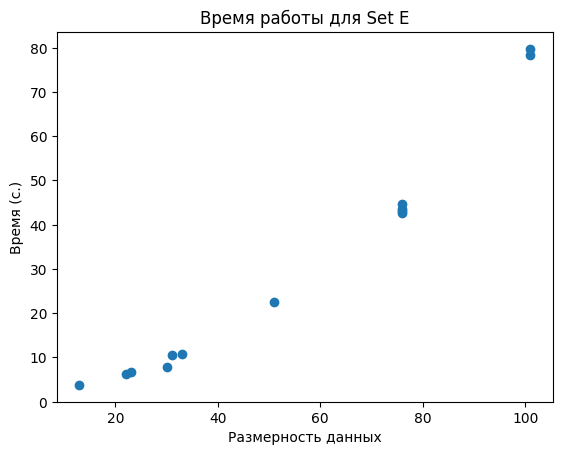

In [469]:
plt.scatter(res1, list_E_time[2:] + list_E_time[:2])
plt.title("Время работы для Set E")
plt.ylabel("Время (с.)")
plt.xlabel("Размерность данных")

# plt.savefig("Время работы для Set E") 
# plt.show()